In [35]:
# imports
%reload_ext autoreload
%autoreload 2

from i2 import Sig
from plunk.sb.sig_compatibility.sig_comp import param_kind_counter, DefinitionSig, CallSig, call_is_compatible, is_compatible_with

# Reminder about signatures

In [36]:
def foo(a, /,b, *args, c,  d=10,**kwargs):
    pass

sig = Sig(foo)

# PO: positional-only, PK: positional or keyword, VP: variadic positional, KO: keyword only, VK: variadic keyword
# get the counts of arguments, by kind
assert param_kind_counter(sig) == {'PO': 1, 'PK': 1, 'VP': 1, 'KO': 2, 'VK': 1}

In [37]:
# another way to encode arguments (without recording their names, only their counts)
# {'PO': 1, 'PK': 1, 'VP': 1, 'KO': 2, 'VK': 1}
d= DefinitionSig(PO= 1, PK= 1, VP= 0, KO= 2, VK=1)

# encode the number of arguments by their types (positional or keyword) in a function call
c = CallSig(pos=1, k=2) # as in the following function call: foo(a, b=2, c=3)

# Ways of calling a function

* Every function with a given signature-size (po,pk,vp,ko,vk) can be called in many different ways, using (p,k) (ie p positional and k keywords) arguments. 
* The possible allowed choices define a region in the plane (p,k).
* Signature1 is compatible with Signature2 if every allowed way of calling func1 is an allowed way of calling func2: a necessary condition is that  region1 is included in region2
* checking the inclusions of infinite regions would involve an infinite number of checks. However, the regions are convex and of a special shape: it is enough to check the inclusions of two corner points. In essence, we use the fact that regions are "invariant under positive translations" to the right or to the top.

## Visualization of regions

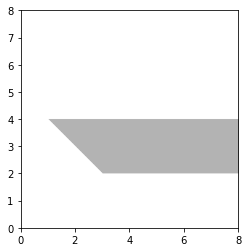

In [38]:
import numpy as np
import matplotlib.pyplot as plt


d = np.linspace(0,8,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((y>=2) & (y<=4)&(5-x<=y)).astype(int) , 
                extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);

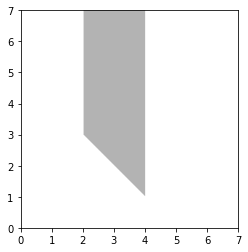

In [39]:
# type 2: ie vk=1 and vp=0, example of an infinite region
# on the x axis: number of positional args in function call, on y-axis: number of keyword args in function call
# here we could use: (pos, pos, at least 3 kw), or (pos, pos, pos, at least 2 kw), or (pos, pos, pos, pos, at least 1 kw)
# allowed function calls can have 

d = np.linspace(0,7,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((x>=2) & (x<=4)&(5-x<=y)).astype(int) , 
                extent=(0.,x.max(),0.,y.max()),origin="lower", cmap="Greys", alpha = 0.3);
 

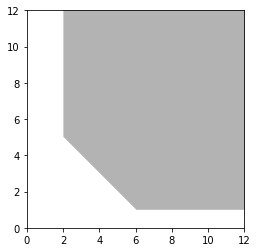

In [40]:
# type 3: all allowed combinations of type (pos, pos, ..., kw, kw, kw, ...) for a signature having vp and vk 
d = np.linspace(0,12,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((x>=2) & (y>=1)&(7-x<=y)).astype(int) , 
                extent=(0.,x.max(),0.,y.max()),origin="lower", cmap="Greys", alpha = 0.3);

In [41]:
# example
d= DefinitionSig(PO= 1, PK= 1, VP= 0, KO= 2, VK=1)
e= DefinitionSig(PO= 1, PK= 1, VP= 0, KO= 2, VK=1)

cc = CallSig(pos=2, k=1)

In [42]:
# can we call a function having signature-size equal to d, with 2 positionals and 1 keyword? Nope, not enough keywords...
assert call_is_compatible(d,cc)==False

In [44]:
# is the region associated with d included in the region associated with e?
assert is_compatible_with(d,e)

# Comparing the regions

All regions inclusions are described by inequalities. Example: if both regions have no variadics, then region1 is inside region2 if and only if the following is true:

$ko_2 >= ko_1$ and $(ko_2+pk_2)<=(ko_1+pk_1)$ and $ko_2+pk_2+po_2 = ko_1+pk_1+po_1$

Same question for pairs (region_type_1, region_type_2) in the list (0,1),  (1,1) :

$ko_2 >= ko_1$ and $(ko_2+pk_2)<=(ko_1+pk_1)$ and $ko_2+pk_2+po_2 >= ko_1+pk_1+po_1$

Same question for pairs (region_type_1, region_type_2) in the list (0,2), (1,2), (2,2) :

$ko_2 >= ko_1$ and $po_2>=po_1$ and $ko_2+pk_2+po_2 >= ko_1+pk_1+po_1$

# The cases where comparison is automatic

|   |  0 |  vp2 |  vk2 | vp2,vk2  |
|---|---|---|---|---|
|  **0** |  ? | ?  | ?  | ?  |
|   **vp1**| F  |  ? | F  |  ? |
|   **vk1**| F  | F  |  ? |  ? |
|   **vp1,vk1**| F  | F  | F  | ? |

Only few cases need to be treated. The first 3 (where sig1 has no vp, no vk) can be treated by enumeration: we generate all possibilities (finitely many cases) and pass them to a simple function having sig2. The cases where vp2=vk2=1 can be treated as the cases below (vk1, vk2).

# The "standard" verification

I call "perform the standard verification" the following: generate inputs for the first function like this
```
(po positionals, n positionals, pk-n keyword, ko keyword) where 0<=n<=pk
```

and verify that func2 accepts them. Observe that this is the complete verification in the case where vp1=vk1=0. 


# The case vk1, vk2

I claim that the standard verification is enough also for this case.

**Strategy**: 
The allowed calls for the first function are exactly of type:
```
General type: (po positionals, n positionals, pk-n keyword, ko keyword, any number of extra keyword) where 0<=n<=pk
```

Now if the second function allows all calls like the following (it is a finite collection):
```
 Particular type: (po positionals, n positionals, pk-n keyword, ko keyword) 
 ```
it will allow also all calls of the General type

because vk2>0.
 


# The case vp1, vp2

Again, I claim that the standard verification is enough also for this case.

**Strategy**: 
The allowed calls for the first function are of two types:
```
Type 1: (po positionals, n positionals, pk-n keyword, ko keyword) where 0<=n<=pk
```
```
Type 2: (po +pk positionals, any number of extra positional, ko keyword)
```
Now if the second function allows all calls of type 1 (it is a finite collection):

it will also allow all calls of type 2

because of the condition vp2>0.

## The case vk2, vp2

Same strategy as above (test the finitely many cases first).